# Homework 2.2: The Quest For A Better Network

In this assignment you will build a monster network to solve CIFAR10 image classification.

This notebook is intended as a sequel to seminar 3, please give it a try if you haven't done so yet.

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 
## Grading
* starting at zero points
* +20% for describing your iteration path in a report below.
* +20% for building a network that gets above 20% accuracy
* +10% for beating each of these milestones on __TEST__ dataset:
    * 50% (50% points)
    * 60% (60% points)
    * 65% (70% points)
    * 70% (80% points)
    * 75% (90% points)
    * 80% (full points)
    
## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([torch.nn docs](http://pytorch.org/docs/master/nn.html))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!


### The main rule of prototyping: one change at a time
   * By now you probably have several ideas on what to change. By all means, try them out! But there's a catch: __never test several new things at once__.


### Optimization
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
   * You should certainly use adaptive optimizers
     * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (nn.BatchNorm2d) for the win!
     * Sometimes more batch normalization is better.
   * __Regularize__ to prevent overfitting
     * Add some L2 weight norm to the loss function, PyTorch will do the rest
       * Can be done manually or like [this](https://discuss.pytorch.org/t/simple-l2-regularization/139/2).
     * Dropout (`nn.Dropout`) - to prevent overfitting
       * Don't overdo it. Check if it actually makes your network better
   
### Convolution architectures
   * This task __can__ be solved by a sequence of convolutions and poolings with batch_norm and ReLU seasoning, but you shouldn't necessarily stop there.
   * [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions (exotic)](https://arxiv.org/abs/1608.06993), [Capsule networks (exotic)](https://arxiv.org/abs/1710.09829)
   * Please do try a few simple architectures before you go for resnet-152.
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment that you try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   
### Data augmemntation
   * getting 5x as large dataset for free is a great 
     * Zoom-in+slice = move
     * Rotate+zoom(to remove black stripes)
     * Add Noize (gaussian or bernoulli)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
     * Other cool libraries: cv2, skimake, PIL/Pillow
   * A more advanced way is to use torchvision transforms:
    ```
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    trainset = torchvision.datasets.CIFAR10(root=path_to_cifar_like_in_seminar, train=True, download=True, transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    ```
   * Or use this tool from Keras (requires theano/tensorflow): [tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), [docs](https://keras.io/preprocessing/image/)
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   
```

```

```

```

```

```

```

```


   
There is a template for your solution below that you can opt to use or throw away and write it your way.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from cifar import load_cifar10
X_train,y_train,X_val,y_val,X_test,y_test = load_cifar10("cifar_data")
class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print(X_train.shape,y_train.shape)

(40000, 3, 32, 32) (40000,)


In [3]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [15]:
cnn = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=50, kernel_size=(3,3), padding=1),
    nn.BatchNorm2d(50),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)),
    nn.Conv2d(in_channels=50, out_channels=100, kernel_size=(3,3), padding=2, dilation=2),
    nn.BatchNorm2d(100),
    nn.Dropout2d(0.4),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2)),
    nn.Conv2d(in_channels=100, out_channels=150, stride = 2, kernel_size=(3,3), padding=1, dilation=1),
    nn.BatchNorm2d(150),
    nn.Dropout2d(0.3),
    nn.ReLU(),
    Flatten(),
    nn.Linear(16 * 150, 512),
    nn.Dropout(0.2),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 10),
    nn.BatchNorm1d(10),
    nn.Softmax(dim=1)
).cuda()

In [16]:
cnn(torch.Tensor(X_train[:5]).cuda()).size()

torch.Size([5, 10])

In [17]:
param_number = 0
for param in cnn.parameters():
    i = 1
    for item in param.size():
        i *= item
    param_number += i
param_number

1479816

In [23]:
def compute_loss(X_batch, y_batch, model):
    X_batch = Variable(torch.FloatTensor(X_batch)).cuda()
    y_batch = Variable(torch.LongTensor(y_batch)).cuda()
    logits = model(X_batch)
    l2_loss = 0
    param_number = 0
    for param in model.parameters():
        i = 1
        for item in param.size():
            i *= item
        param_number += i
        l2_loss += (param * param).sum()
    return F.cross_entropy(logits, y_batch).mean() + l2_loss * 0.01 / param_number

__ Training __

In [24]:
from torchvision import transforms

transform_augment = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation([-30, 30]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

from torchvision.datasets import CIFAR10
train_loader = CIFAR10("./cifar_data/", train=True, transform=transform_augment)

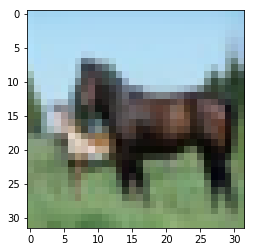

In [25]:
plt.imshow(train_loader.train_data[12])

In [26]:
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

train_batch_gen = torch.utils.data.DataLoader(train_loader, 
                                                      batch_size=128,
                                                      shuffle=True,
                                                      num_workers=1)

opt = torch.optim.Adam(cnn.parameters())

train_loss = []
val_accuracy = []
from torch.optim.lr_scheduler import StepLR
import time
num_epochs = 100 
batch_size = 128 
sched1 = StepLR(opt, step_size=60, gamma = 0.1)
sched2 = StepLR(opt, step_size=80, gamma = 0.1)
sched3 = StepLR(opt, step_size=90, gamma = 0.1)

In [30]:
try:
    for epoch in range(num_epochs):
        start_time = time.time()
        sched1.step()
        sched2.step()
        sched3.step()
        
        cnn.train(True) 
        for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
            loss = compute_loss(X_batch, y_batch, cnn)
            loss.backward()
            opt.step()
            opt.zero_grad()
            train_loss.append(loss.data.cpu().numpy())
   
        for (x_batch, y_batch) in train_batch_gen:
            loss = compute_loss(x_batch, y_batch, cnn)
            loss.backward()
            opt.step()
            opt.zero_grad()
            train_loss.append(loss.data.cpu().numpy())
            
        cnn.train(False)
        for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
            logits = cnn(Variable(torch.FloatTensor(X_batch)).cuda())
            y_pred = logits.max(1)[1].data.cpu().numpy()
            val_accuracy.append(np.mean(y_batch == y_pred))

        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(X_train) // batch_size - train_loader.train_data.shape[0] // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))
except KeyboardInterrupt:
    pass

Epoch 1 of 100 took 108.564s
  training loss (in-iteration): 	1.957021
  validation accuracy: 			57.66 %
Epoch 2 of 100 took 107.572s
  training loss (in-iteration): 	1.913710
  validation accuracy: 			65.50 %
Epoch 3 of 100 took 111.965s
  training loss (in-iteration): 	1.888098
  validation accuracy: 			66.55 %
Epoch 4 of 100 took 110.559s
  training loss (in-iteration): 	1.868989
  validation accuracy: 			68.52 %
Epoch 5 of 100 took 110.434s
  training loss (in-iteration): 	1.856414
  validation accuracy: 			66.83 %
Epoch 6 of 100 took 112.146s
  training loss (in-iteration): 	1.844265
  validation accuracy: 			68.84 %
Epoch 7 of 100 took 111.827s
  training loss (in-iteration): 	1.838185
  validation accuracy: 			66.94 %
Epoch 8 of 100 took 109.577s
  training loss (in-iteration): 	1.830069
  validation accuracy: 			71.36 %
Epoch 9 of 100 took 108.243s
  training loss (in-iteration): 	1.823638
  validation accuracy: 			72.23 %
Epoch 10 of 100 took 110.431s
  training loss (in-itera

In [34]:
cnn.train(False)
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = cnn(Variable(torch.FloatTensor(X_batch)).cuda())
    y_pred = logits.max(1)[1].data.cpu().numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)
    
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

if test_accuracy * 100 > 95:
    print("Double-check, than consider applying for NIPS'17. SRSly.")
elif test_accuracy * 100 > 90:
    print("U'r freakin' amazin'!")
elif test_accuracy * 100 > 80:
    print("Achievement unlocked: 110lvl Warlock!")
elif test_accuracy * 100 > 70:
    print("Achievement unlocked: 80lvl Warlock!")
elif test_accuracy * 100 > 60:
    print("Achievement unlocked: 70lvl Warlock!")
elif test_accuracy * 100 > 50:
    print("Achievement unlocked: 60lvl Warlock!")
else:
    print("We need more magic! Follow instructons below")

Final results:
  test accuracy:		81.90 %
Achievement unlocked: 110lvl Warlock!


```

```

```

```

```

```


# Report

All creative approaches are highly welcome, but at the very least it would be great to mention
* the idea;
* brief history of tweaks and improvements;
* what is the final architecture and why?
* what is the training method and, again, why?
* Any regularizations and other techniques applied and their effects;


There is no need to write strict mathematical proofs (unless you want to).
 * "I tried this, this and this, and the second one turned out to be better. And i just didn't like the name of that one" - OK, but can be better
 * "I have analized these and these articles|sources|blog posts, tried that and that to adapt them to my problem and the conclusions are such and such" - the ideal one
 * "I took that code that demo without understanding it, but i'll never confess that and instead i'll make up some pseudoscientific explaination" - __not_ok__

## Отчёт.

Сначала я взял сеть поменьше, чтобы на ней потестировать все "плюшки", которые предлагались в качестве улучшающих результат. В ней было 2 свёрточных и 2 полносвязных слоя, при этом агресcивно уменьшался размер входа путём использования stride и max pooling. 

#### 1) Батчнормы и дропауты. 
Наставил везде, где только можно. Качество улучшалось, сеть училась.

#### 2) Аугментация.
Я человек простой: вижу код - беру. Убрал только нормализацию оттуда. Потыкал в индексы, посмотрел на картинки, вроде преобразования их не сильно испортили. Учиться стало дольше, но результат повысился.

#### 3) Регуляризация функции потерь.
Хотел брал ту штуку, что по ссылке шла, но с ней пришлось повозиться, а ещё она не очень хорошо работала. Я, когда тестировал, добавил ещё l1-регуляризацию, возможно, она всё поломала. Тут я забыл, что человек простой, и написал свою реализацию, где руками доставал параметры и применял модуль / возведение в квадрат. Потом считал среднее по всем параметрам и умножал на 0.01. Без l1-регуляризации (код вытер) стало лучше. Игрался с весом (брал 0.1, 0.01, 1), мне больше всего понравился вариант с 0.01, т.к. обучение менее штормило, а регуляризатор есть.

#### 4) Изменение шага обучения.
Нашёл самый удобный вариант реализации и вставил, сначала было только 2 уменьшения learning rate, step_size=45. С той эпохи, как lr уменьшался, наблюдалось более быстрое уменьшение функции потерь на обучающей выборке. Для финальной версии я решил, что стоит сделать несколько таких "встрясок", но при этом на стандартном значении параметра я давал 60 эпох с аугментацией, это меня обнадёживало в смысле того, что вдруг я рано замедлил темп обучения. Оставил в итоге тот вариант, который есть (уменьшаем на 60-й, 80-й и 90-й эпохах).

#### 5) Итоговая сеть.
Ограничился 3 свёрточными и 3 линейными слоями. Сначала было 2 линейных, но потом добавил ещё один, и стало лучше. Идея свёрточных слоёв была в том, чтобы по размерностям уменшить картинку в 8 раз, а receptive field был побольше (поэтому вторая свёртка с dliation=2), при этом выход последнего свёрточного слоя хотелось оставить, пэотому только 2 пулинга, но добавил stride=2. 

Сначала пробовал сетки с меньшим числом нейронов, но 80% качества на тестовом множестве не достигал. Пытался понемногу добавлять число каналов в свёрточных слоях, но не хватало немного до 80%. В некоторый момент мне это надоело, и я сделал ЕЩЁ БОЛЬШЕ НЕЙРОНОВ НУ ЧТОБЫ УЖЕ ТОЧНО ПОЛУЧИТЬ ACCURACY 80%, одолжил мощный комп и получил требуемое качество - 81.90% на тестовом множестве и 83.03% на валидационном.

### Hi, my name is `___ ___`, and here's my story

A long time ago in a galaxy far far away, when it was still more than an hour before the deadline, i got an idea:

##### I gonna build a neural network, that
* brief text on what was
* the original idea
* and why it was so

How could i be so naive?!

##### One day, with no signs of warning,
This thing has finally converged and
* Some explaination about what were the results,
* what worked and what didn't
* most importantly - what next steps were taken, if any
* and what were their respective outcomes

##### Finally, after __  iterations, __ mugs of [tea/coffee]
* what was the final architecture
* as well as training method and tricks

That, having wasted ____ [minutes, hours or days] of my life training, got

* accuracy on training: __
* accuracy on validation: __
* accuracy on test: __


[an optional afterword and mortal curses on assignment authors]